In [1]:
# Imports and configuration
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext line_profiler
%config InlineBackend.figure_format = 'retina'
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)

In [2]:
# Model Parameters
from core import model
from core import settingsloader

experiment_settings = {
    "Server": {
        'max_steps': 1500
    },
    "Model": {
        "num_agents": 100,
        "continuous_order_matching": True
    }
}


def run_sim(progress_bar=True):
    """Run and return a havven simulation"""
    
    settings = settingsloader.load_settings()
    
    for category in experiment_settings:
        for setting in experiment_settings[category]:
            settings[category][setting] = experiment_settings[category][setting]
    
    model_settings = settings['Model']
    model_settings['agent_fractions'] = settings['AgentFractions']

    m = model.HavvenModel(
        model_settings,
        settings['Fees'],
        settings['Agents'],
        settings['Havven']
    )
    
    if progress_bar:
        for _ in tqdm(range(settings["Server"]["max_steps"])):
            m.step()
    else:
        for _ in range(settings["Server"]["max_steps"]):
            m.step()
    
    return m

In [3]:
# Run the model here
havven = run_sim()

  1%|          | 10/1500 [00:00<00:15, 98.34it/s]

Loading settings from settings.ini


100%|██████████| 1500/1500 [00:13<00:00, 110.95it/s]


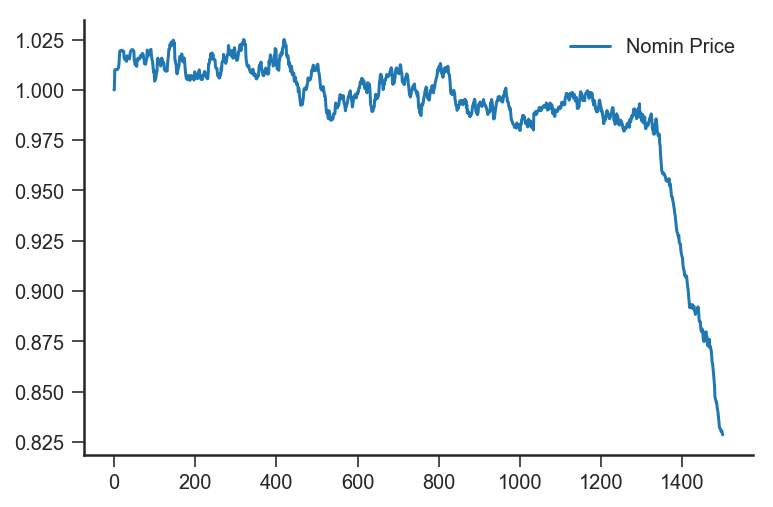

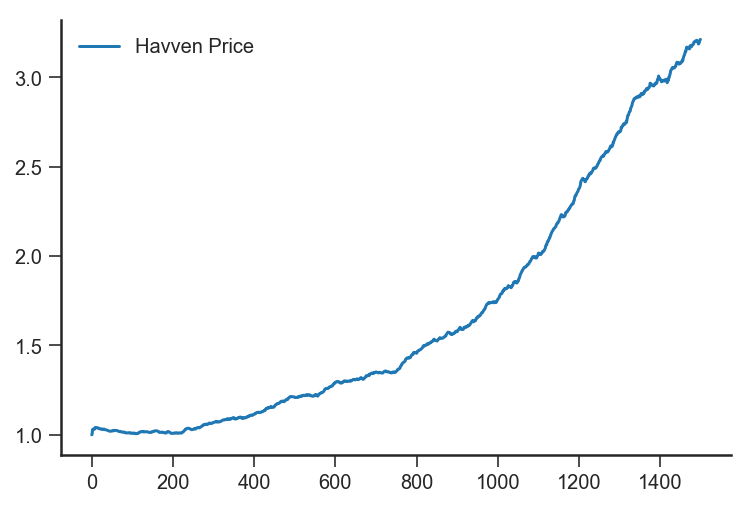

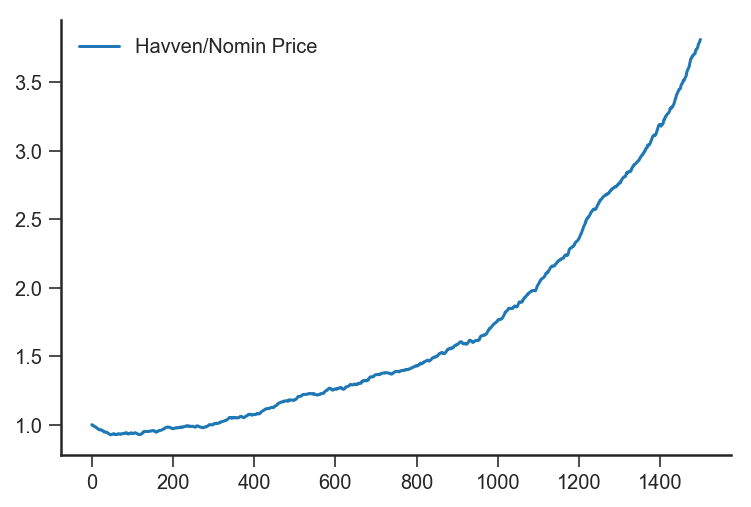

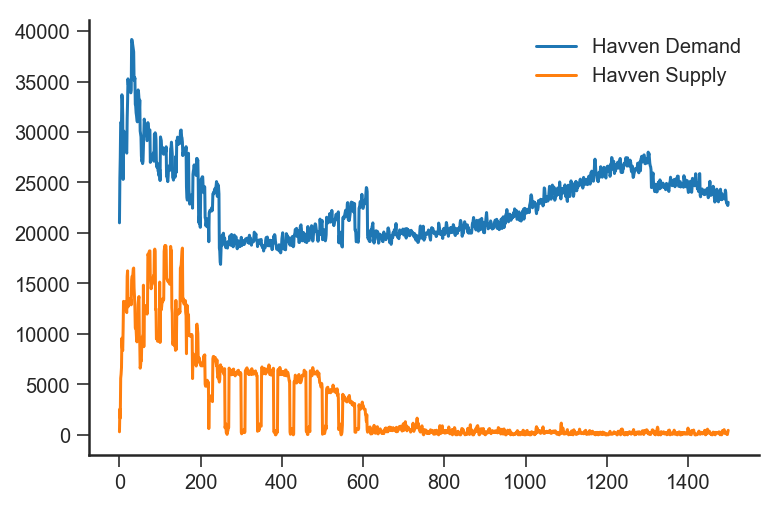

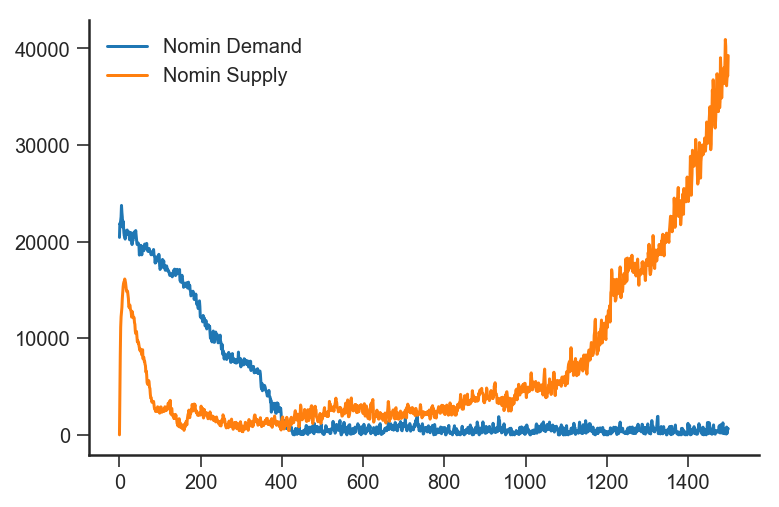

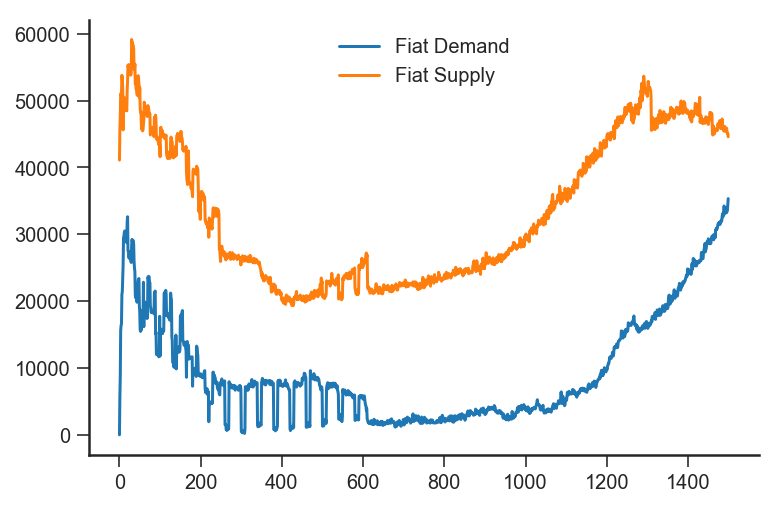

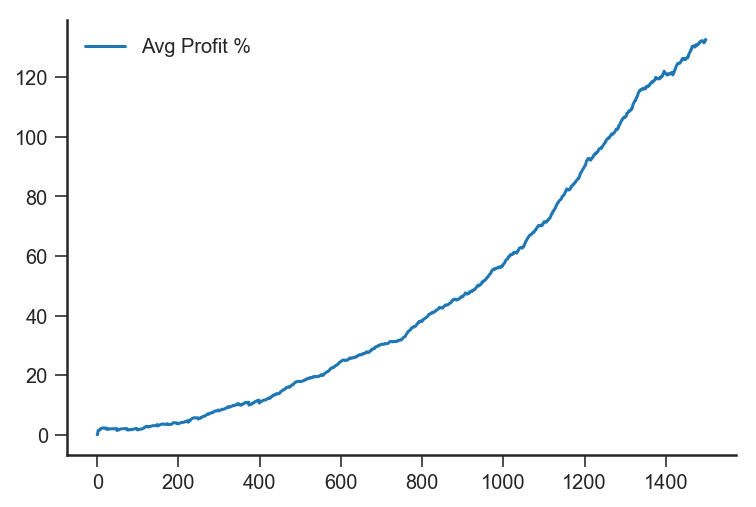

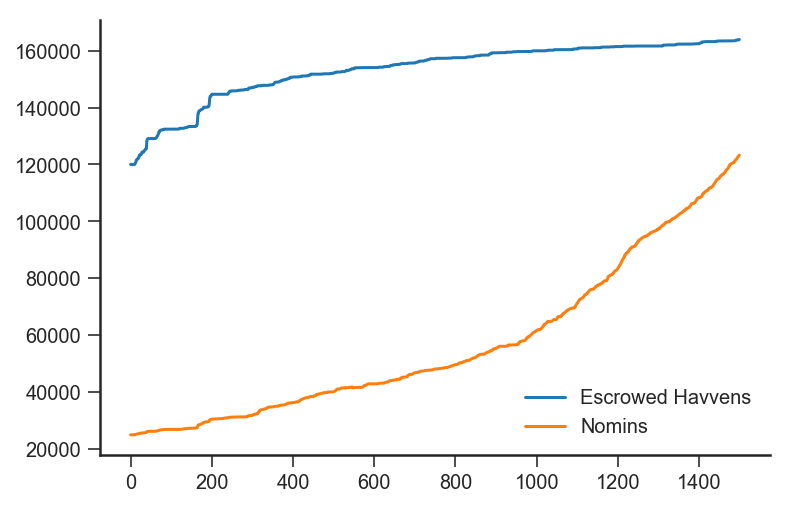

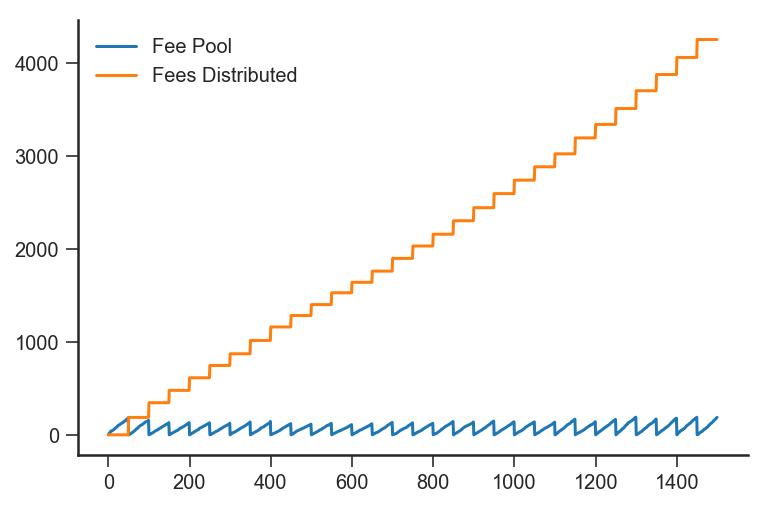

In [4]:
# Collect and plot the data

df = havven.datacollector.get_model_vars_dataframe()
df[["Nomin Price"]].plot()
df[["Havven Price"]].plot()
df[["Havven/Nomin Price"]].plot()
df[["Havven Demand", "Havven Supply"]].plot()
df[["Nomin Demand", "Nomin Supply"]].plot()
df[["Fiat Demand", "Fiat Supply"]].plot()
df[["Avg Profit %"]].plot()
df[["Escrowed Havvens", "Nomins"]].plot()
df[["Fee Pool", "Fees Distributed"]].plot()

plt.show()

In [5]:
# Profiling
# import agents, orderbook

# Overall sim
# Result: 99.8% time spent in m.step()
# %lprun -f run_sim run_sim(False)

# Individual sim steps
# Result: 83% in agent.step(); 17% in datacollector.collect()
# %lprun -f model.Havven.step run_sim(False)

# Per-agent sim steps
# Result: ~40% each in agents.MarketPlayer.sell_fiat_for_havvens and sell_nomins_for_havvens,
#         8% in OrderBook.Order.cancel
# %lprun -f agents.Banker.step run_sim(False)

# Market player trades
# Result: 92% in OrderBook.buy, 6% in OrderBook.lowest_ask_price
# %lprun -f agents.MarketPlayer.sell_fiat_for_havvens run_sim(False)
# %lprun -f agents.MarketPlayer.sell_nomins_for_havven:s run_sim(False)

# Order cancellations
# Result: 74% in OrderBook.buy_orders.remove, 8% in Orderbook.step,
#         6% in agents.MarketPlayer.notify_cancelled, 5% in agents.MarketPlayer.orders.remove
# %lprun -f orderbook.Bid.cancel run_sim(False)
# %lprun -f orderbook.Ask.cancel run_sim(False)

# Orderbook buy and ask prices
# Result: 93% orderbook.OrderBook.bid, 6% orderbook.OrderBook.lowest_ask_price
# %lprun -f orderbook.OrderBook.buy run_sim(False)

# Orderbook bid
# Result: 79% orderbook.OrderBook.match, 20% construction of Bids
# %lprun -f orderbook.OrderBook.bid run_sim(False)

# Matching functions
# Results: 24% match loop condition, 10% grabbing prev asks and bids from order lists
#          32% matcher functions, 16% spread calculation, 15% recalculating prices.
# %lprun -f orderbook.OrderBook.match run_sim(False)

# Bid construction
# Result: 22% superconstructor, 5% issuer order set addition,
#         59% order book buy order addition, 9% book.step
# %lprun -f orderbook.Bid.__init__ run_sim(False)